# Analysis and Recommendation Model for Lawyer Earnings Data

- Student: Thi Mai Pham
- GitHub link: https://github.com/thimaipham/CEU_DA3_Assignment1


In [165]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder


In [166]:
#Load original data which from cleaned_data folder on OSF
full_data = pd.read_csv('https://raw.githubusercontent.com/thimaipham/Data/main/morg-2014-emp.csv', 
                        dtype={16: str})

In [167]:
#Check data infomation
full_data.head(2)

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.0,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.0,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent


In [168]:
# Filter the dataset for the occupation 
# "Lawyers, Judges, magistrates, and other judicial workers" (occupation code 2100)
occupation_code = 2100
data = full_data[full_data['occ2012'] == occupation_code]

# Count the number of observations for this occupation
data.shape[0]

1027

###### This filter data include 1027 observations

## 1. Feture Engineering

In [169]:
# Checking for missing values
missing_values = data.isnull().sum()

# Examining data types
data_types = data.dtypes

# Display the results
print(missing_values, data_types) 



Unnamed: 0      0
hhid            0
intmonth        0
stfips          0
weight          0
earnwke         0
uhours          0
grade92         0
race            0
ethnic        981
age             0
sex             0
marital         0
ownchild        0
chldpres        0
prcitshp        0
state           0
ind02           0
occ2012         0
class           0
unionmme        0
unioncov       57
lfsr94          0
dtype: int64 Unnamed: 0      int64
hhid            int64
intmonth       object
stfips         object
weight        float64
earnwke       float64
uhours          int64
grade92         int64
race            int64
ethnic        float64
age             int64
sex             int64
marital         int64
ownchild        int64
chldpres        int64
prcitshp       object
state          object
ind02          object
occ2012         int64
class          object
unionmme       object
unioncov       object
lfsr94         object
dtype: object


#### 1.1 Missing values:
- `ethnic` and `unioncov` are 2 variables which contains many missing values. I will choose to drop some columns which I think might not be unnecessary (base on the missing values and domain knowledge). 

In [170]:
# Remove additional unnecessary columns
columns_to_remove = ['Unnamed: 0', 'ethnic', 'unioncov', 'intmonth', 'unionmme', 'lfsr94', 'state', 'ind02', 'occ2012']
data_cleaned = data.drop(columns_to_remove, axis=1)

# Checking for any remaining missing values
missing_values_cleaned = data_cleaned.isnull().sum()
print("Missing values in cleaned data:", missing_values_cleaned)

# Create a new variable 'earnings_per_hour'
data_cleaned['earnings_per_hour'] = data_cleaned['earnwke'] / data_cleaned['uhours']

# Display the first few rows of the data with the new variable
data_cleaned[['earnwke', 'uhours', 'earnings_per_hour']].head()


Missing values in cleaned data: hhid        0
stfips      0
weight      0
earnwke     0
uhours      0
grade92     0
race        0
age         0
sex         0
marital     0
ownchild    0
chldpres    0
prcitshp    0
class       0
dtype: int64


,earnwke,uhours,earnings_per_hour
23,1442.30,50,28.84600
295,1384.61,40,34.61525
659,2307.00,50,46.14000
764,700.00,50,14.00000
901,2884.61,50,57.69220


### 1.2. Charts and distributions:

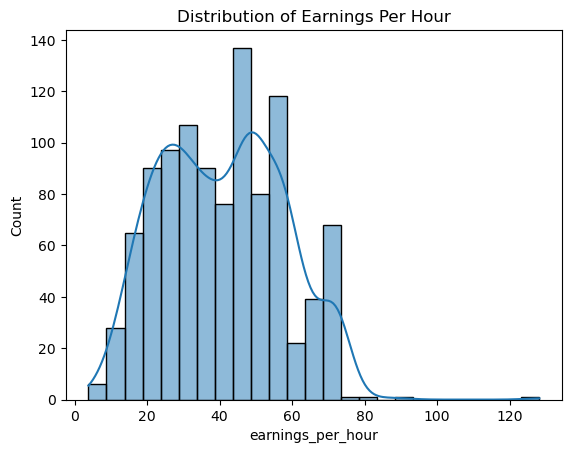

In [171]:
# Visualize the distribution of 'earnings_per_hour'
sns.histplot(data_cleaned['earnings_per_hour'], kde=True)
plt.title('Distribution of Earnings Per Hour')
plt.show()

##### It seems to have a few extreme values more than 100. I will drop the values. This might helps my models become more clear.

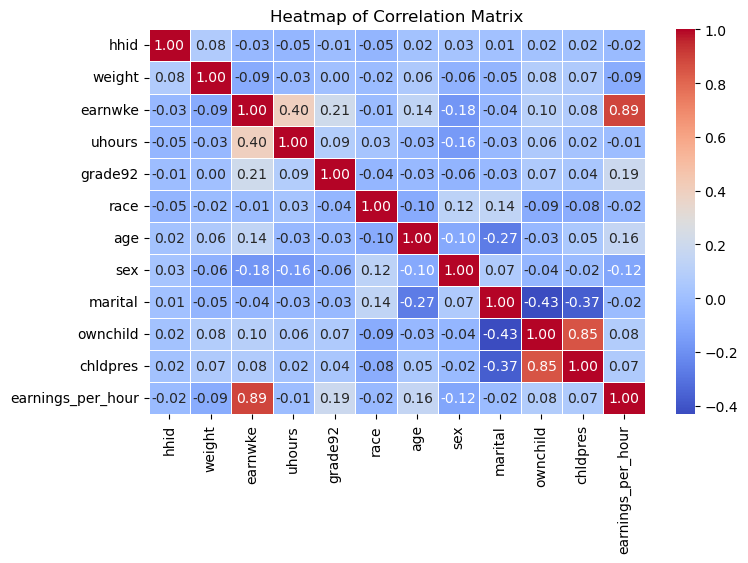

In [172]:
# Filter 'earnings_per_hour' < 100
data_filtered = data_cleaned[data_cleaned['earnings_per_hour'] < 100]

# Caculate correlation 
correlation_matrix = data_filtered.corr()

# Create heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


##### From the heatmap, it does not show any clear correlationship between `earnings_per_hours` and other variables. `grade92`, `age`, `sex` might have a weak relationship with `earnings_per_hours` . But it does not tell much, so I will do some simple regression for the following steps

### 1.3. Dealing with categorical variables

In [173]:
# Choosing some categorical variables which I want to use
categorical_cols = ['race', 'sex', 'marital', 'grade92', 'class', 'prcitshp']

# Using One-Hot Encoding
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_data = encoder.fit_transform(data_filtered[categorical_cols])

# Create data frame from encoded data
encoded_columns = encoder.get_feature_names_out(categorical_cols)
data_encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Concat with data_cleaned
data_cleaned_encoded = data_filtered.drop(categorical_cols, axis=1).reset_index(drop=True)
data_cleaned_encoded = pd.concat([data_cleaned_encoded, data_encoded_df], axis=1)

# Target variable
y_encoded = data_cleaned_encoded['earnings_per_hour']


## 2. Models 

In [174]:
# Classify predictors
# Grade92
grade92_specific_columns = ['grade92_38', 'grade92_39', 'grade92_40', 'grade92_41', 
                            'grade92_42', 'grade92_43', 'grade92_44', 'grade92_45', 'grade92_46']

#prcitshp - Citizenship status
prcitshp_specific_colums = ['prcitshp_Foreign Born, US Cit By Naturalization',
                            'prcitshp_Native, Born Abroad Of US Parent(s)',
                            'prcitshp_Native, Born In US',
                            'prcitshp_Native, Born in PR or US Outlying Area']
# class - class of worker
class_specific_columns = [ 'class_Government - Local', 'class_Government - State',
                          'class_Private, For Profit', 'class_Private, Nonprofit']

#race
race_specific_columns = ['race_2', 'race_3', 'race_4', 'race_5',
                         'race_6', 'race_7', 'race_8', 'race_10', 'race_11']
# marital - marriage status
marital_specific_columns = [ 'marital_2', 'marital_3', 'marital_4', 'marital_5', 'marital_6', 'marital_7']


### 2.1 Building Model 1 using `age` as the predictor

In [176]:
# Building Model 1 using 'age' as the predictor
X1 = sm.add_constant(data_cleaned_encoded[['age']])
model_1 = sm.OLS(y_encoded, X1).fit()

# Evaluating Model 1
predicted_earnings_1 = model_1.predict(X1)
rmse_1 = round(np.sqrt(mean_squared_error(y_encoded, predicted_earnings_1)),3)
bic_1 = round(model_1.bic,3)

# Print the results
print("RMSE of Model 1:", rmse_1)
print("BIC of Model 1:", bic_1)

RMSE of Model 1: 16.534
BIC of Model 1: 8682.252


### 2.2. Building model 2  using `age` + `grade92`  as the predictor

In [177]:
# Building Model 2 using 'age' and specific 'grade92' categories as predictors
predictors_model_2 = ['age'] + grade92_specific_columns

# Adding a constant to the model
X2 = sm.add_constant(data_cleaned_encoded[predictors_model_2])

# Fitting the OLS model
model_2 = sm.OLS(y_encoded, X2).fit()

# Evaluating Model 2
# Predicting earnings and calculating RMSE
predicted_earnings_2 = model_2.predict(X2)
rmse_2 = round(np.sqrt(mean_squared_error(y_encoded, predicted_earnings_2)),3)
bic_2 = round(model_2.bic,3)

# Printing the results
print("RMSE of Model 2:", rmse_2)
print("BIC of Model 2:", bic_2)



RMSE of Model 2: 15.952
BIC of Model 2: 8671.093


### 2.3. Building model 3 using `age` + `sex` +  `grade92` + `prcitshp` + `class` + `race` as the predictor

In [178]:
# Dedine predictors
predictors_model_3 = ['age', 'sex_2'] + grade92_specific_columns + prcitshp_specific_colums + class_specific_columns + race_specific_columns

# Adding a constant to the model
X3 = sm.add_constant(data_cleaned_encoded[predictors_model_3])

# Fitting the OLS model
model_3 = sm.OLS(y_encoded, X3).fit()

# Evaluating Model 3
# Predicting earnings and calculating RMSE
predicted_earnings_3 = model_3.predict(X3)
rmse_3 = round(np.sqrt(mean_squared_error(y_encoded, predicted_earnings_3)),3)
bic_3 = round(model_3.bic,3)

# Printing the results
print("RMSE of Model 3:", rmse_3)
print("BIC of Model 3:", bic_3)



RMSE of Model 3: 15.465
BIC of Model 3: 8732.276


### 2.4. Building model 4 using `age` + `sex` +  `grade92` + `prcitshp` + `class` + `race` + `ownchild` + `marital` as the predictor

In [179]:
# Define predictor model 4
predictors_model_4 = ['age', 'sex_2', 'ownchild'] + grade92_specific_columns + prcitshp_specific_colums + class_specific_columns + race_specific_columns +marital_specific_columns

# Adding a constant to the model
X4 = sm.add_constant(data_cleaned_encoded[predictors_model_4])

# Fitting the OLS model
model_4 = sm.OLS(y_encoded, X4).fit()

# Evaluating Model 4
# Predicting earnings and calculating RMSE
predicted_earnings_4 = model_4.predict(X4)
rmse_4 = round(np.sqrt(mean_squared_error(y_encoded, predicted_earnings_4)),3)
bic_4 = round(model_4.bic,3)

# Printing the results
print("RMSE of Model 4:", rmse_4)
print("BIC of Model 4:", bic_4)


RMSE of Model 4: 15.331
BIC of Model 4: 8762.979


In [180]:
# Function to perform cross-validation and calculate RMSE
def cross_validated_rmse(X, y):
    model = LinearRegression()
    neg_mse = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    rmse = np.sqrt(-neg_mse)
    return rmse.mean()

# Calculating cross-validated RMSE for each model
cv_rmse_1 = round(cross_validated_rmse(X1, y_encoded), 3)
cv_rmse_2 = round(cross_validated_rmse(X2, y_encoded), 3)
cv_rmse_3 = round(cross_validated_rmse(X3, y_encoded), 3)
cv_rmse_4 = round(cross_validated_rmse(X4, y_encoded), 3)

# Results for cross-validated RMSE
cv_rmse_1, cv_rmse_2, cv_rmse_3, cv_rmse_4


(16.566, 16.112, 15.965, 16.0)

In [181]:
# Compare the results:
model_results = [
    {'Model': 'Model 1', 'RMSE': rmse_1, 'Cross-validated RMSE':cv_rmse_1, 'BIC': bic_1},
    {'Model': 'Model 2', 'RMSE': rmse_2, 'Cross-validated RMSE': cv_rmse_2, 'BIC': bic_2},
    {'Model': 'Model 3', 'RMSE': rmse_3, 'Cross-validated RMSE': cv_rmse_3, 'BIC': bic_3},
    {'Model': 'Model 4', 'RMSE': rmse_4,'Cross-validated RMSE':cv_rmse_4,  'BIC': bic_4}
]
model_results = pd.DataFrame(model_results)

#Show the results
model_results

,Model,RMSE,Cross-validated RMSE,BIC
0,Model 1,16.534,16.566,8682.252
1,Model 2,15.952,16.112,8671.093
2,Model 3,15.465,15.965,8732.276
3,Model 4,15.331,16.000,8762.979


## 4. Discussions:

### 4.1. Model Performance Comparison:

- RMSE (Full Sample): **Model 4** demonstrated the lowest RMSE, indicating the best fit on the training data.
- Cross-Validated RMSE: Contrary to initial expectations, **Model 3** exhibited a slightly better cross-validated RMSE than **Model 2**, suggesting a marginally superior generalization capability.
- BIC: Despite this, **Model 2** achieved the lowest BIC, indicating an efficient balance between model complexity and fit.

### 4.2 Ploting the results

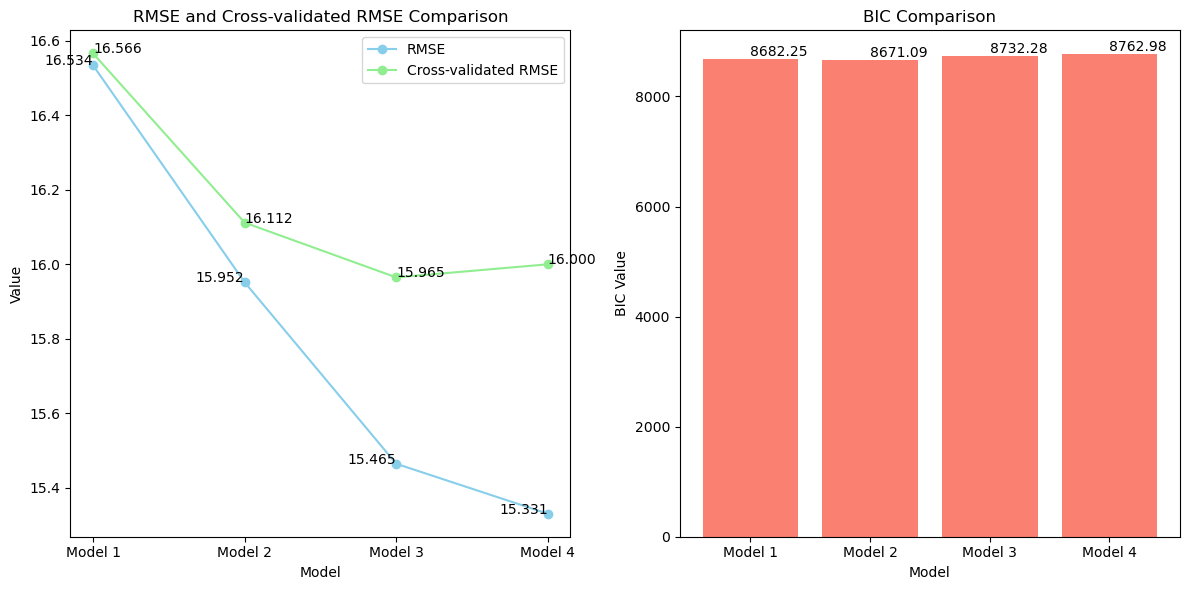

In [182]:
# Plot
plt.figure(figsize=(12, 6))

# RMSE and Cross-validated RMSE
plt.subplot(1, 2, 1)
plt.plot(model_results['Model'], model_results['RMSE'], label='RMSE', marker='o', color='skyblue')
plt.plot(model_results['Model'], model_results['Cross-validated RMSE'], 
         label='Cross-validated RMSE', marker='o', color='lightgreen')

# Adding text for each point
for i in range(len(model_results)):
    plt.text(model_results['Model'][i], model_results['RMSE'][i], f'{model_results["RMSE"][i]:.3f}', ha='right')
    plt.text(model_results['Model'][i], model_results['Cross-validated RMSE'][i], f'{model_results["Cross-validated RMSE"][i]:.3f}', ha='left')

plt.title('RMSE and Cross-validated RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('Value')
plt.legend()

# BIC
plt.subplot(1, 2, 2)
bars = plt.bar(model_results['Model'], model_results['BIC'], color='salmon')

# Adding text for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.title('BIC Comparison')
plt.xlabel('Model')
plt.ylabel('BIC Value')

plt.tight_layout()
plt.show()


## Discussions:
### 4.2.Graphical Observations:
- The graphs for RMSE and BIC show a trend where Model 4, being the most complex, has the lowest RMSE on the training data but does not generalize as well as Models 2 or 3.
- In the cross-validated RMSE graph, Model 3 performs slightly better than Model 2, which is an important consideration in evaluating model generalizability.

### 4.3. Relationship Between Model Complexity and Performance:
- Higher complexity models, like **Model 4**, did not necessarily translate to better generalization, as seen in the cross-validation results.
- **Model 3**, despite its slightly better cross-validated RMSE compared to **Model 2**, has a higher BIC, which could indicate overfitting due to its complexity.
- **Model 2**, with its lower complexity compared to **Model 3**, provides a more balanced approach. It achieves a slightly higher cross-validated RMSE but has the lowest BIC, suggesting it is the most efficient model in balancing fit and complexity.

## 5. Inclusion: 
Given these insights, while **Model 3** shows marginally better performance in cross-validation, **Model 2** is still preferable due to its optimal balance of complexity, performance on unseen data, and overall model efficiency as indicated by its lower BIC. This makes **Model 2** a more practical choice for predicting lawyers' earnings per hour.